# Bangla Cyberbullying Classification with XGBoost

This notebook implements an XGBoost classifier for multi-class classification of Bangla cyberbullying text.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.preprocessing import label_binarize
from bnlp import SentencepieceTokenizer
from bnlp.embedding.fasttext import BengaliFasttext
from sklearn.preprocessing import LabelEncoder
import time
from itertools import cycle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

warnings.filterwarnings("ignore")

# Set plot style
plt.style.use("ggplot")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

## 1. Loading and Exploring Datasets


In [2]:
# 1. Load the dataset
print("Loading dataset...")
original_cleaned_df = pd.read_csv("../../dataset/cleaned/original_cleaned.csv")

print(f"Original dataset shape: {original_cleaned_df.shape}")

Loading dataset...
Original dataset shape: (41907, 6)


In [3]:
# Display the first few rows of original dataset
original_cleaned_df.head()

,comment,Category,Gender,comment react number,label,text_length
0,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...,Actor,Female,1.0,sexual,128
1,ঘরে শুট কেমন লেগেছে ক্যামেরাতে,Singer,Male,2.0,not bully,30
2,অরে বাবা টা পাগল,Actor,Female,2.0,not bully,16
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully,21
4,পটকা মাছ,Politician,Male,0.0,troll,8


## 2. Label Mapping and Visualization


In [4]:
# Map the labels for the dataset
label_mapping = {"not bully": 0, "troll": 1, "sexual": 2, "religious": 3, "threat": 4}

original_cleaned_df["label_encoded"] = original_cleaned_df["label"].map(label_mapping)

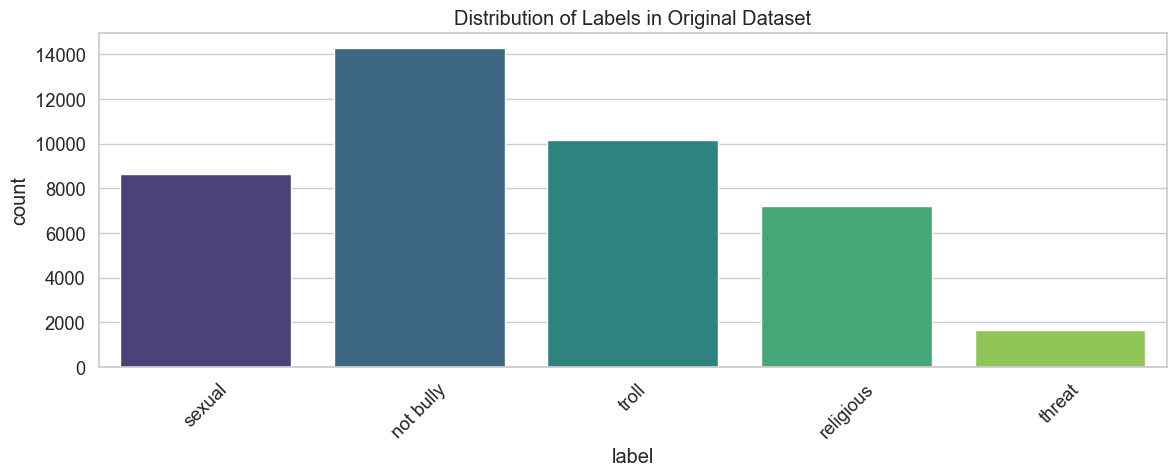

In [5]:
# Check the distribution of labels
plt.figure(figsize=(12, 5))
sns.countplot(x="label", data=original_cleaned_df, palette="viridis")
plt.title("Distribution of Labels in Original Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Data Splitting


In [6]:
# Split the original dataset into train and test sets
X = original_cleaned_df["comment"]
y = original_cleaned_df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 33525
Test set size: 8382


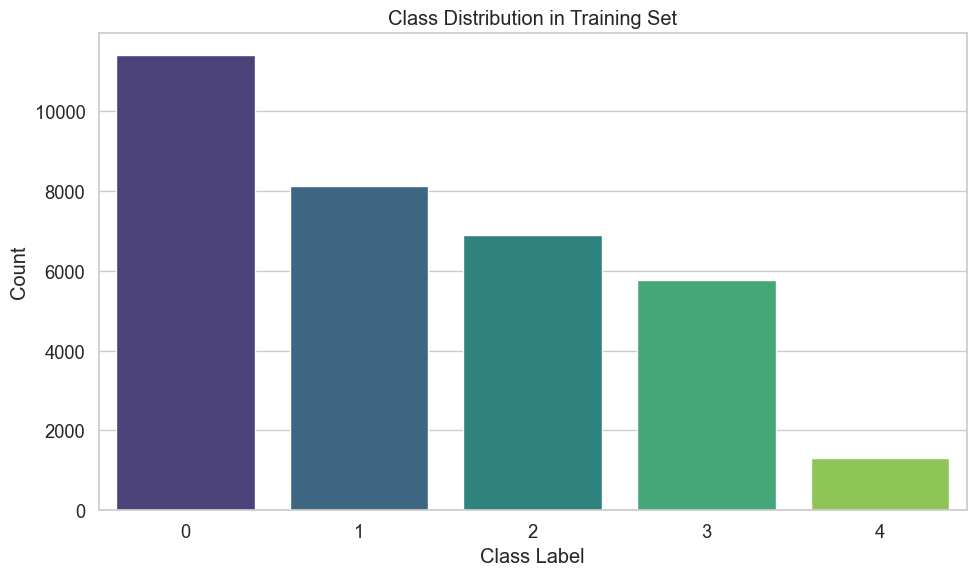

In [7]:
# Visualize the class distribution in the training set
plt.figure(figsize=(10, 6))

sns.countplot(x=y_train, palette="viridis")
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Label")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## 4. Text Tokenization and Vectorization


In [8]:
# Initialize SentencepieceTokenizer and BengaliFasttext
print("Initializing tokenizer and word embedding model...")
sp_tokenizer = SentencepieceTokenizer()
fasttext_model = BengaliFasttext()

Initializing tokenizer and word embedding model...


In [9]:
def tokenize_and_vectorize(text):
    # Tokenize the text
    tokens = sp_tokenizer.tokenize(text)

    # Get vector for each token and average them
    vectors = [
        fasttext_model.get_word_vector(token) for token in tokens if token.strip()
    ]

    # If no valid vectors, return zeros
    if not vectors:
        return np.zeros(300)  # FastText typically uses 300-dimensional vectors

    # Average the vectors
    return np.mean(vectors, axis=0)

In [10]:
# Apply tokenization and vectorization to training data
print("Vectorizing training data...")
start_time = time.time()
X_train_vectors = np.array([tokenize_and_vectorize(text) for text in X_train])
print(
    f"Training data vectorization completed in {time.time() - start_time:.2f} seconds"
)

Vectorizing training data...
Training data vectorization completed in 6.98 seconds


In [11]:
# Apply tokenization and vectorization to testing data
print("Vectorizing testing data...")
start_time = time.time()
X_test_vectors = np.array([tokenize_and_vectorize(text) for text in X_test])
print(f"Testing data vectorization completed in {time.time() - start_time:.2f} seconds")

Vectorizing testing data...
Testing data vectorization completed in 1.66 seconds


## 5. Training XGBoost Model


In [12]:
# Configure and train XGBoost classifier
print("Training XGBoost model...")
# Parameters optimized for text embeddings
xgb_model = xgb.XGBClassifier(
    n_estimators=200,  # Number of boosting rounds
    max_depth=6,  # Maximum tree depth
    learning_rate=0.1,  # Step size shrinkage to prevent overfitting
    min_child_weight=3,  # Minimum sum of instance weight needed in a child
    gamma=0.1,  # Minimum loss reduction needed for partition
    subsample=0.8,  # Fraction of samples used for fitting trees
    colsample_bytree=0.8,  # Fraction of features used for fitting trees
    objective="multi:softproba",  # Multiclass probability
    num_class=5,  # Number of classes
    scale_pos_weight=1,  # Weight of positive examples
    random_state=42,
    n_jobs=-1,  # Use all processors
)

start_time = time.time()
xgb_model.fit(X_train_vectors, y_train)
training_time = time.time() - start_time
print(f"Model trained in {training_time:.2f} seconds")

Training XGBoost model...
Model trained in 9.02 seconds


## 6. Model Evaluation - Basic Metrics


In [13]:
# Make predictions and calculate basic metrics
print("Evaluating model...")
y_pred = xgb_model.predict(X_test_vectors)

# Calculate basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model...
Accuracy: 0.6460
Precision: 0.6449
Recall: 0.6460
F1 Score: 0.6380


In [14]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=list(label_mapping.keys())))

Classification Report:
              precision    recall  f1-score   support

   not bully       0.68      0.78      0.73      2852
       troll       0.56      0.55      0.55      2031
      sexual       0.59      0.53      0.56      1726
   religious       0.76      0.75      0.76      1443
      threat       0.71      0.19      0.30       330

    accuracy                           0.65      8382
   macro avg       0.66      0.56      0.58      8382
weighted avg       0.64      0.65      0.64      8382



## 7. Confusion Matrix Visualization


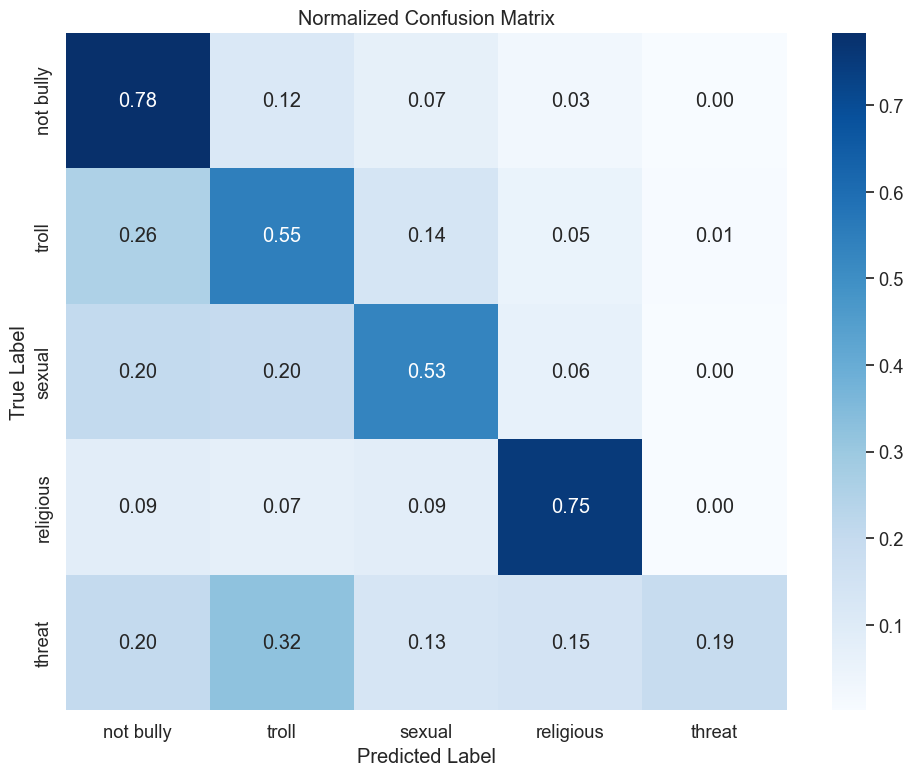

In [15]:
# Create and display confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis


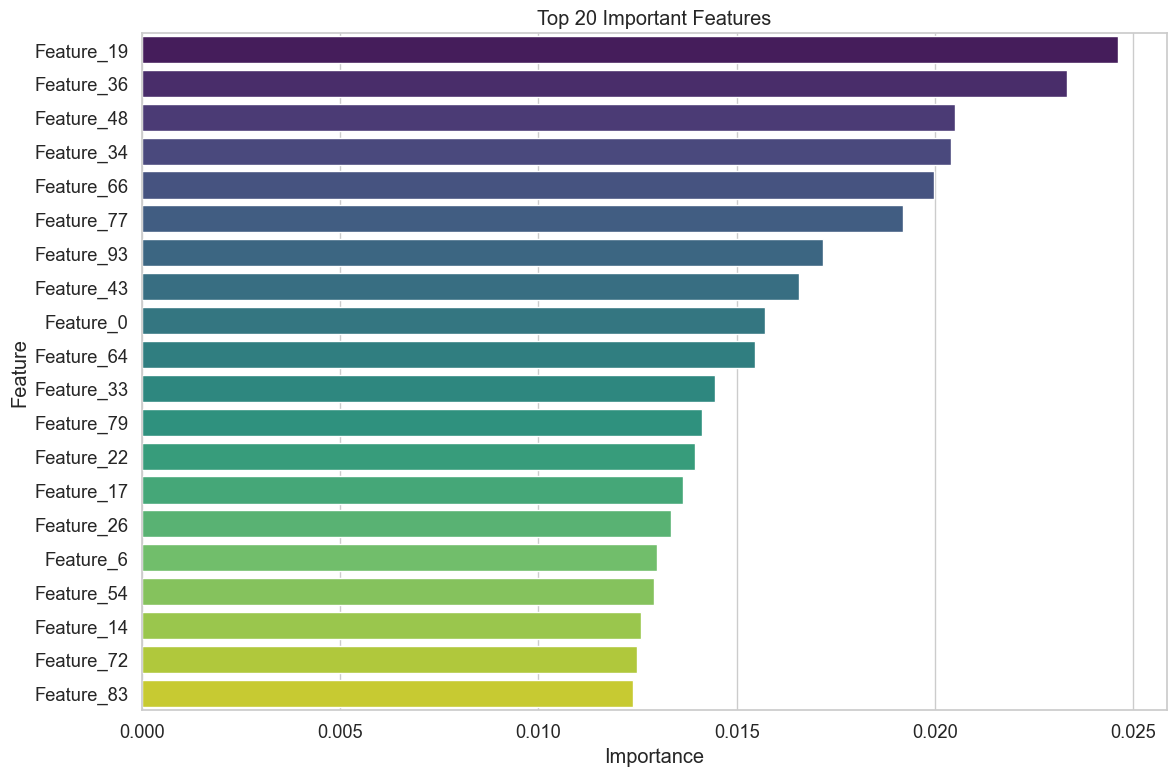

In [16]:
# Analyze feature importance
feature_importance = pd.DataFrame(
    {
        "Feature": [f"Feature_{i}" for i in range(X_train_vectors.shape[1])],
        "Importance": xgb_model.feature_importances_,
    }
)
feature_importance = feature_importance.sort_values("Importance", ascending=False).head(
    20
)

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="viridis")
plt.title("Top 20 Important Features")
plt.tight_layout()
plt.show()

## 9. ROC Curve Analysis


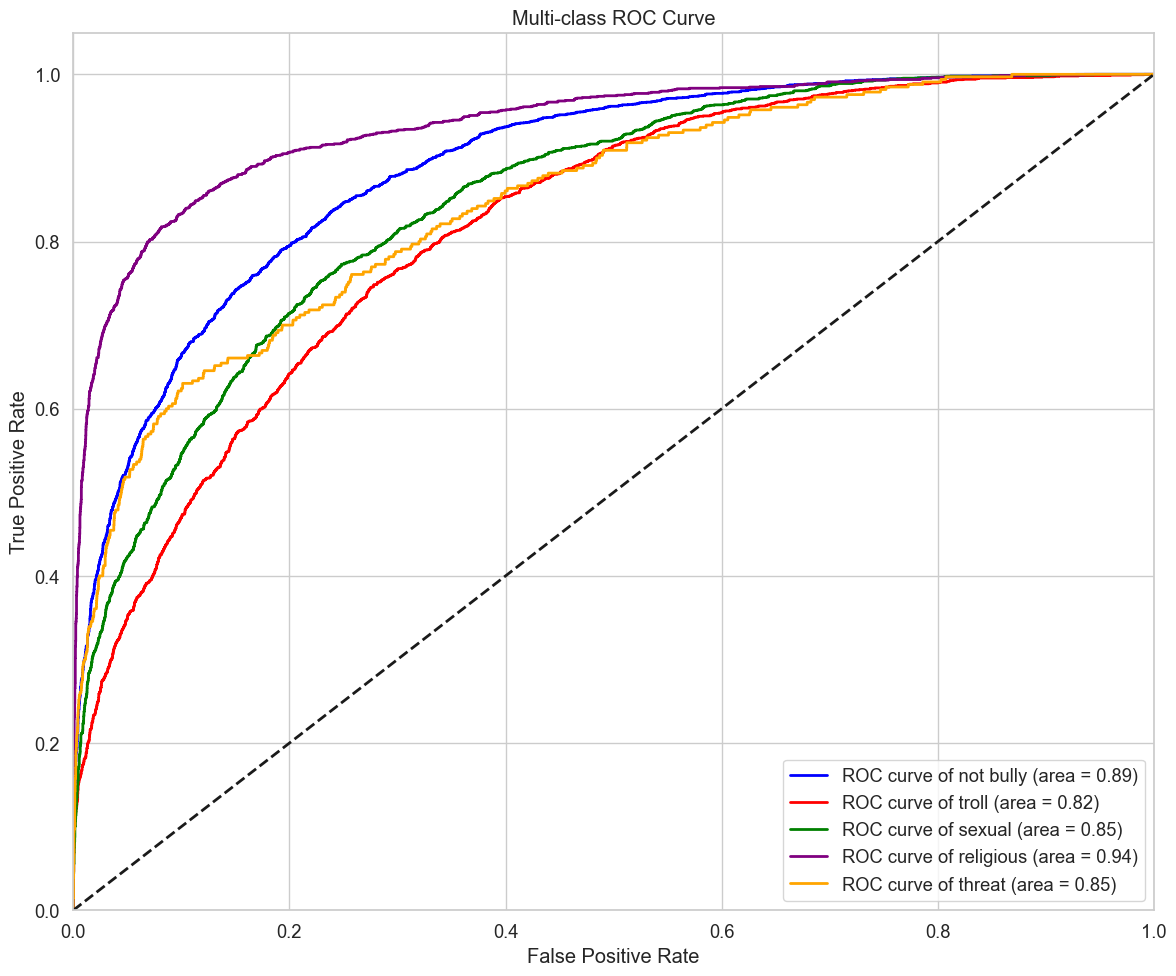

In [17]:
# ROC Curve and AUC for each class
# Binarize the output for ROC curve
y_test_bin = label_binarize(y_test, classes=range(5))
y_score = xgb_model.predict_proba(X_test_vectors)

# Calculate ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 10))
colors = cycle(["blue", "red", "green", "purple", "orange"])
class_names = list(label_mapping.keys())

for i, color, class_name in zip(range(5), colors, class_names):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"ROC curve of {class_name} (area = {roc_auc[i]:.2f})",
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 10. Precision-Recall Curve Analysis


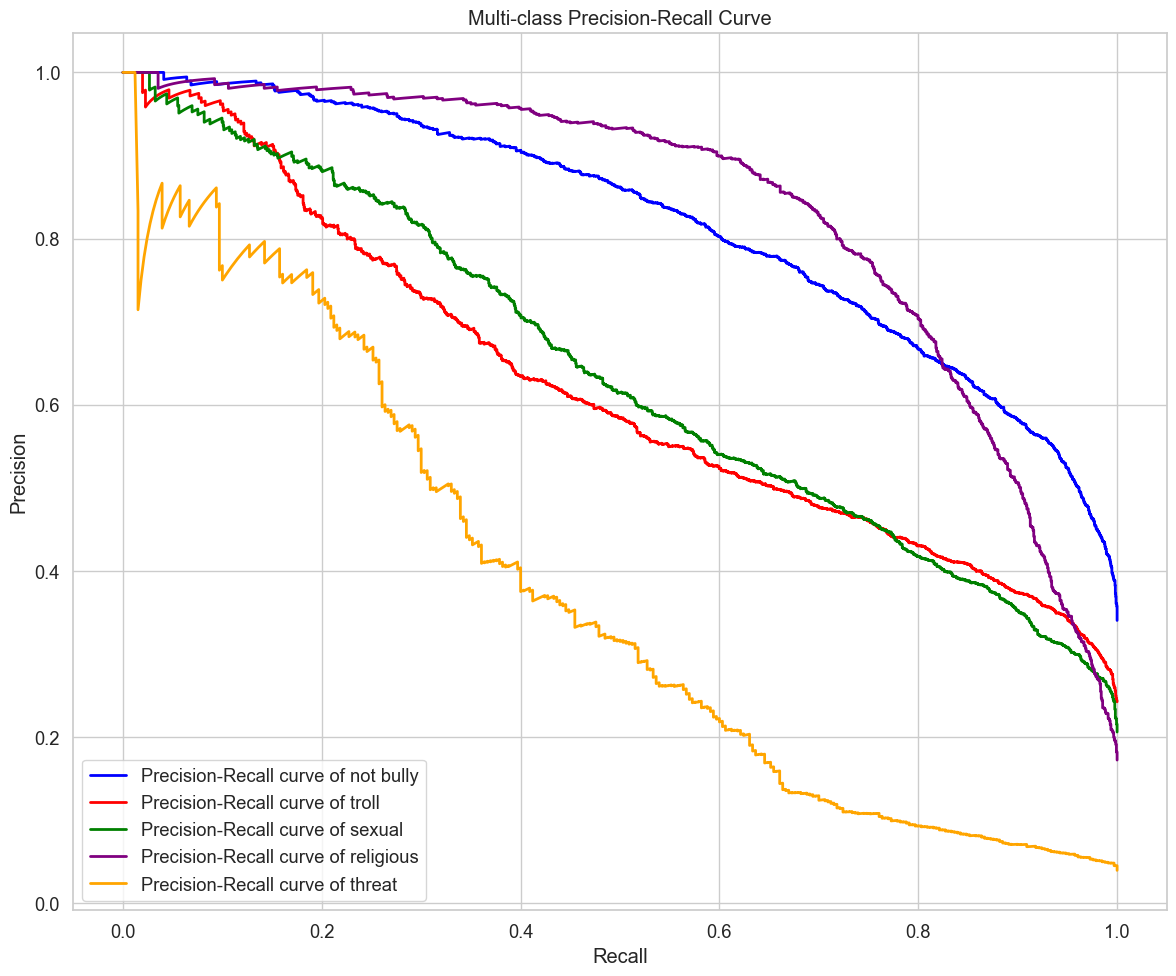

In [18]:
# Calculate Precision-Recall curve and average precision for each class
precision = {}
recall = {}
plt.figure(figsize=(12, 10))

for i, color, class_name in zip(range(5), colors, class_names):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(
        recall[i],
        precision[i],
        color=color,
        lw=2,
        label=f"Precision-Recall curve of {class_name}",
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## 12. Model Summary and Saving


In [19]:
# Summary of the binary classification model
print("Binary Classification Model Summary:")
print(f"Total samples in training set: {len(X_train)}")
print(f"Total samples in test set: {len(X_test)}")
print(f"Number of features (vector dimension): {X_train_vectors.shape[1]}")
print(f"Final model accuracy on test set: {accuracy:.4f}")
plt.show()

Binary Classification Model Summary:
Total samples in training set: 33525
Total samples in test set: 8382
Number of features (vector dimension): 100
Final model accuracy on test set: 0.6460


In [20]:
# Save the model if needed
import joblib

joblib.dump(xgb_model, "../../models/xgboost/multiclass_no_augment_xgboost.pkl")

['../../models/xgboost/multiclass_no_augment_xgboost.pkl']